In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

# Transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = trainset.classes

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# cuda means NVIDIA GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


 ship   cat   cat  frog


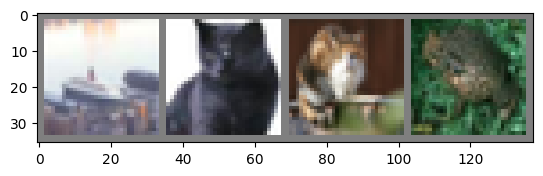

In [4]:
def show_images(img, mean, std):
    # Un-normalize the image and plot it
    mean = torch.tensor(mean, device=img.device)
    std = torch.tensor(std, device=img.device)
    img = img.permute(1, 2, 0)
    img = img * std + mean
    plt.imshow(img.numpy())


# fetch a batch from the train dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
nimages = min(batch_size, 4)
norm = transform.transforms[-1]
show_images(torchvision.utils.make_grid(images[:nimages]), norm.mean, norm.std)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(nimages)))

## Fully-connected network

In [5]:
class FullyConnectedNet(nn.Module):
	def __init__(self):
		super(FullyConnectedNet, self).__init__()
		self.fc1 = nn.Linear(3 * 32 * 32, 512)
		self.fc2 = nn.Linear(512, 512)
		self.fc3 = nn.Linear(512, 128)
		self.fc4 = nn.Linear(128, 10)

	def forward(self, x):
		# flatten input
		x = x.view(x.size(0), -1)
		x = torch.relu(self.fc1(x))
		x = torch.relu(self.fc2(x))
		x = torch.relu(self.fc3(x))
		x = self.fc4(x)
		return x

## Train and test functions

In [6]:
def evaluate_model(model, dataloader):
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in dataloader:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	model.train()
	return correct / total

def train_test(model, criterion, optimizer, epochs=5):
	train_accuracies = []
	test_accuracies = []
	for epoch in range(epochs):
		running_loss = 0.0
		correct_train = 0
		total_train = 0
		for inputs, labels in trainloader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

			# Calculate training accuracy per batch
			_, predicted = torch.max(outputs, 1)
			total_train += labels.size(0)
			correct_train += (predicted == labels).sum().item()

		# Calculate epoch training accuracy
		train_accuracy = correct_train / total_train
		train_accuracies.append(train_accuracy)

		# Evaluate the model on the test dataset
		test_accuracy = evaluate_model(model, testloader)
		test_accuracies.append(test_accuracy)
		print(f"Epoch {epoch + 1}: Training Loss = {running_loss / len(trainloader):.4f}, Training Accuracy = {train_accuracy * 100:.2f}%, Test Accuracy = {test_accuracy * 100:.2f}%")
	return np.array(train_accuracies), np.array(test_accuracies)

In [7]:
def plot_accuracy(train_accuracies, test_accuracies, epochs, title):
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 100)
    plt.plot(range(1, epochs + 1), train_accuracies*100, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), test_accuracies*100, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Training and Test Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

## Train fully-connected network

In [8]:
fc_model = FullyConnectedNet()
print(summary(fc_model, input_size=(batch_size, 3, 32, 32)))
# print(fc_model)
fc_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
FullyConnectedNet                        [64, 10]                  --
├─Linear: 1-1                            [64, 512]                 1,573,376
├─Linear: 1-2                            [64, 512]                 262,656
├─Linear: 1-3                            [64, 128]                 65,664
├─Linear: 1-4                            [64, 10]                  1,290
Total params: 1,902,986
Trainable params: 1,902,986
Non-trainable params: 0
Total mult-adds (M): 121.79
Input size (MB): 0.79
Forward/backward pass size (MB): 0.59
Params size (MB): 7.61
Estimated Total Size (MB): 8.99


FullyConnectedNet(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Small Convolutional Neural Network

In [9]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)  # Adjusted for pooling

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [10]:
conv3_model = ConvNet3()
print(summary(conv3_model, input_size=(batch_size, 3, 32, 32)))
# print(conv3_model)
conv3_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet3                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─Conv2d: 1-2                            [64, 64, 16, 16]          18,496
├─Conv2d: 1-3                            [64, 128, 8, 8]           73,856
├─Linear: 1-4                            [64, 10]                  20,490
Total params: 113,738
Trainable params: 113,738
Non-trainable params: 0
Total mult-adds (M): 665.58
Input size (MB): 0.79
Forward/backward pass size (MB): 29.37
Params size (MB): 0.45
Estimated Total Size (MB): 30.61


ConvNet3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

## Fancy VGG-style CNN

In [11]:
class VGGStyleNet(nn.Module):
    def __init__(self):
        super(VGGStyleNet, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [12]:
vgg_model = VGGStyleNet()
print(summary(vgg_model, input_size=(batch_size, 3, 32, 32)))
# print(vgg_model)
vgg_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
VGGStyleNet                              [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          36,928
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-5                    [64, 64, 16, 16]          --
├─Sequential: 1-2                        [64, 128, 8, 8]           --
│    └─Conv2d: 2-6                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         147,584
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-10                   [64, 128, 8, 8]           --

VGGStyleNet(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)


## Train models

Epoch 1: Training Loss = 1.6597, Training Accuracy = 40.85%, Test Accuracy = 46.44%
Epoch 2: Training Loss = 1.4364, Training Accuracy = 49.13%, Test Accuracy = 50.45%
Epoch 3: Training Loss = 1.3187, Training Accuracy = 53.29%, Test Accuracy = 51.46%
Epoch 4: Training Loss = 1.2209, Training Accuracy = 56.52%, Test Accuracy = 52.89%
Epoch 5: Training Loss = 1.1291, Training Accuracy = 59.82%, Test Accuracy = 53.62%
Epoch 6: Training Loss = 1.0490, Training Accuracy = 62.54%, Test Accuracy = 54.47%
Epoch 7: Training Loss = 0.9691, Training Accuracy = 65.27%, Test Accuracy = 54.27%
Epoch 8: Training Loss = 0.8867, Training Accuracy = 68.23%, Test Accuracy = 53.64%
Epoch 9: Training Loss = 0.8140, Training Accuracy = 70.81%, Test Accuracy = 53.40%
Epoch 10: Training Loss = 0.7369, Training Accuracy = 73.52%, Test Accuracy = 54.27%


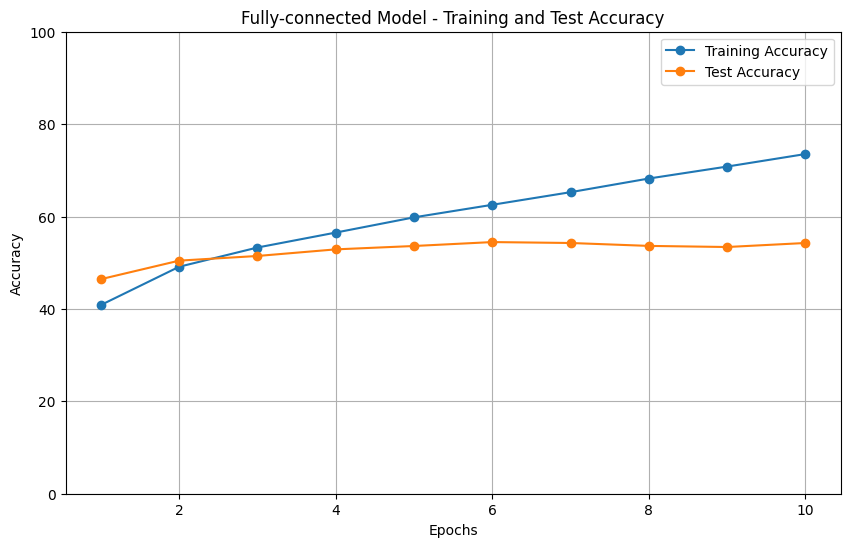

Epoch 1: Training Loss = 1.3671, Training Accuracy = 51.10%, Test Accuracy = 61.51%
Epoch 2: Training Loss = 0.9576, Training Accuracy = 66.41%, Test Accuracy = 68.77%
Epoch 3: Training Loss = 0.7896, Training Accuracy = 72.61%, Test Accuracy = 72.08%
Epoch 4: Training Loss = 0.6898, Training Accuracy = 76.03%, Test Accuracy = 72.76%
Epoch 5: Training Loss = 0.6105, Training Accuracy = 79.02%, Test Accuracy = 73.86%
Epoch 6: Training Loss = 0.5419, Training Accuracy = 81.18%, Test Accuracy = 75.02%
Epoch 7: Training Loss = 0.4785, Training Accuracy = 83.41%, Test Accuracy = 75.33%
Epoch 8: Training Loss = 0.4227, Training Accuracy = 85.16%, Test Accuracy = 74.09%
Epoch 9: Training Loss = 0.3724, Training Accuracy = 87.05%, Test Accuracy = 75.22%
Epoch 10: Training Loss = 0.3260, Training Accuracy = 88.57%, Test Accuracy = 74.44%


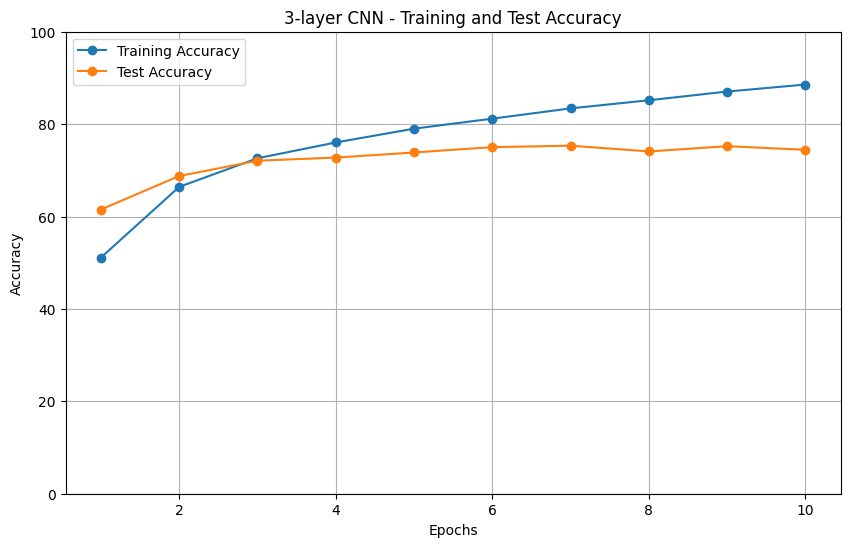

Epoch 1: Training Loss = 1.5288, Training Accuracy = 43.51%, Test Accuracy = 54.53%
Epoch 2: Training Loss = 0.9828, Training Accuracy = 65.12%, Test Accuracy = 69.70%
Epoch 3: Training Loss = 0.7589, Training Accuracy = 73.36%, Test Accuracy = 68.35%
Epoch 4: Training Loss = 0.6189, Training Accuracy = 78.17%, Test Accuracy = 76.11%
Epoch 5: Training Loss = 0.5095, Training Accuracy = 81.88%, Test Accuracy = 76.08%
Epoch 6: Training Loss = 0.4167, Training Accuracy = 85.14%, Test Accuracy = 76.52%
Epoch 7: Training Loss = 0.3356, Training Accuracy = 87.93%, Test Accuracy = 77.38%
Epoch 8: Training Loss = 0.2697, Training Accuracy = 90.22%, Test Accuracy = 77.21%
Epoch 9: Training Loss = 0.2137, Training Accuracy = 92.51%, Test Accuracy = 77.72%
Epoch 10: Training Loss = 0.1859, Training Accuracy = 93.47%, Test Accuracy = 76.88%


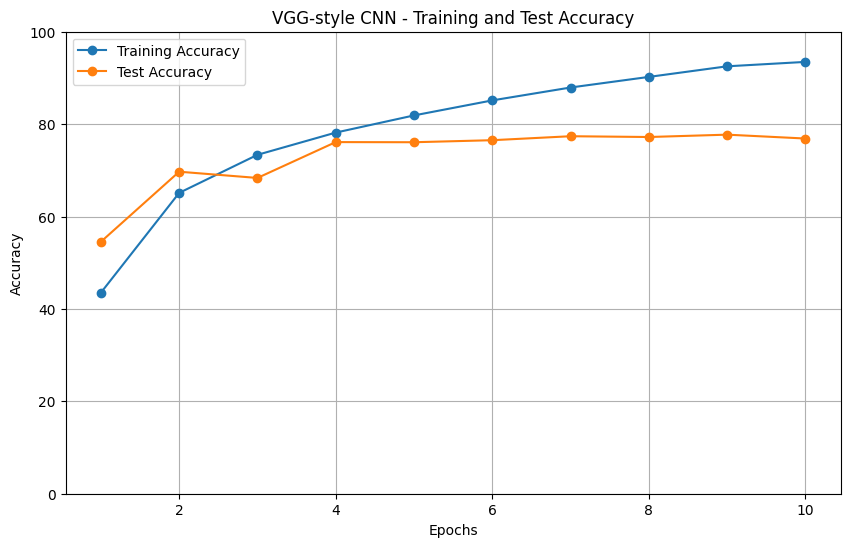

In [13]:
criterion = nn.CrossEntropyLoss()
models = [fc_model, conv3_model, vgg_model]
model_names = ["Fully-connected Model", "3-layer CNN", "VGG-style CNN"]
EPOCHS = 10
best_model = None
best_accuracy = 0.0

for i in range(len(models)):
	optimizer = optim.Adam(models[i].parameters(), lr=0.001)
	train_accuracies, test_accuracies = train_test(models[i], criterion, optimizer, EPOCHS)
	if test_accuracies[-1] > best_accuracy:
		best_accuracy = test_accuracies[-1]
		best_model = models[i]
	plot_accuracy(train_accuracies, test_accuracies, EPOCHS, model_names[i])

## Show predictions

In [18]:
print(f"The best model was: {best_model}\n with an accuracy of {best_accuracy*100:.2f}%")

The best model was: VGGStyleNet(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_featur

GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog
Predicted:    cat  ship airplane airplane  frog  frog truck  deer


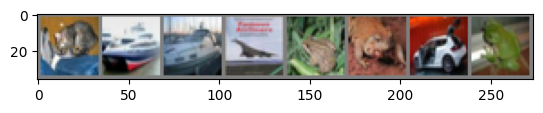

In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
nimages = min(batch_size, 8)
norm = testset.transform.transforms[-1]
show_images(torchvision.utils.make_grid(images[:nimages]), norm.mean, norm.std)
print('GroundTruth: ', ' '.join('%5s' % testset.classes[labels[j]] for j in range(nimages)))

# get predictions of best model
with torch.no_grad():
    inputs, labels = images.to(device), labels.to(device)
    outputs = best_model(inputs)
    _, preds = torch.max(outputs, 1)

# Print the predicted labels
print('Predicted: ', ' '.join('%5s' % testset.classes[preds[j]] for j in range(nimages)))